In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
#sns.set(style='darkgrid')
from numpy import pi,sin,cos,exp
from numpy.linalg import inv

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [2]:
'''Let's generate our synthetic data'''
'''Our Data contains following components:
    1. Trend
    2. Constant Amplitude Seasonality (Annual and Semi-Annual)
    4. Random noise following normal distibution having mean zero and variance = 1 '''
def amp_mod(t):
    g = exp(2*(sin(t)))
    return g

a= 40 # intercept
b= 45 #velocity term
c= 5
d= 7
e= 9
f= 11

np.random.seed(19) #setting random seed = 19
N = 1000 # number of daily epochs
t = np.arange(0,N)/365
trend = a+b*t


# Constant Amplitude Seasonality
periodic1 = c*sin(2*pi*t) + d*cos(2*pi*t)  # Annual
periodic2 = e*sin(4*pi*t) + f*cos(4*pi*t)  # Semi-Annual


seasonality = periodic1+periodic2

noise = np.random.randn(1000)*10

F = trend+seasonality+noise
 


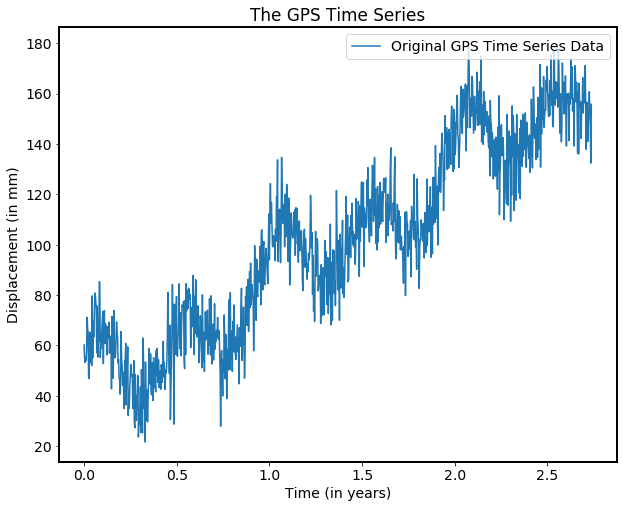

In [3]:
plt.plot(t,F,label = 'Original GPS Time Series Data')

plt.legend(loc='upper right')
plt.xlabel("Time (in years)")
plt.ylabel("Displacement (in mm)")
plt.title("The GPS Time Series")
plt.savefig('Original_series.png')
plt.show()

In [4]:

# Detrend
reg = LinearRegression()
reg.fit(t.reshape(-1,1),F.reshape(-1,1))
trend_hat = reg.intercept_ + reg.coef_*t.reshape(-1,1)
F = F.reshape(-1,1) - trend_hat
F = F- np.mean(F) # Removing the mean of detrended data

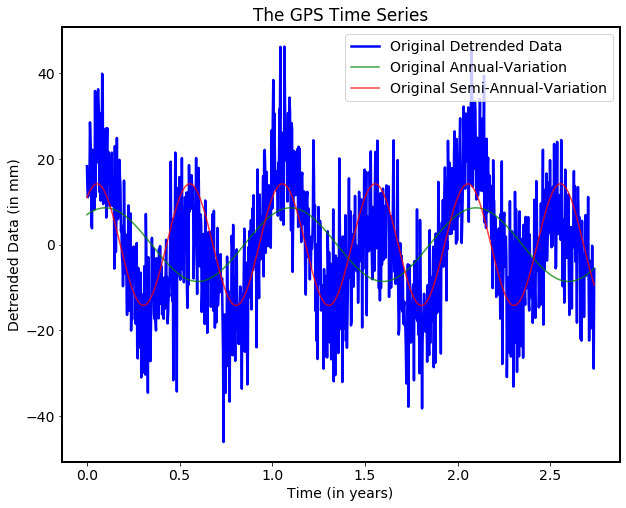

In [5]:
plt.plot(t,F, lw=2.5,color ='blue',label='Original Detrended Data')
plt.plot(t, periodic1, alpha=0.75,color='green',label='Original Annual-Variation')
plt.plot(t, periodic2, alpha=0.75,color='red',label='Original Semi-Annual-Variation')

plt.legend(loc='upper right')
plt.xlabel("Time (in years)")
plt.ylabel("Detrended Data (in mm)")
plt.title("The GPS Time Series")
plt.savefig('Original_detrend_with_components_series.png')
plt.show()

# SSA

In [6]:
L = 370 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.

# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])


In [7]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.


U, Sigma, V = np.linalg.svd(X)
V = V.T 

X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

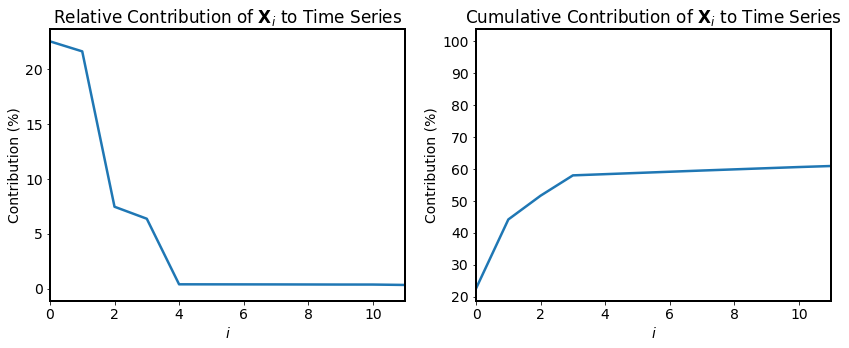

In [8]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Time Series")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Time Series")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");
plt.savefig('Relative_and_cumulative_contri_sigma.png')
plt.show()

In [9]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

In [10]:
# Assemble the grouped components of the time series based on the sigma-graph.
#F_trend = X_to_TS(X_elem[[0]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[0,1]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[2,3]].sum(axis=0))
F_noise = X_to_TS(X_elem[4:].sum(axis=0))

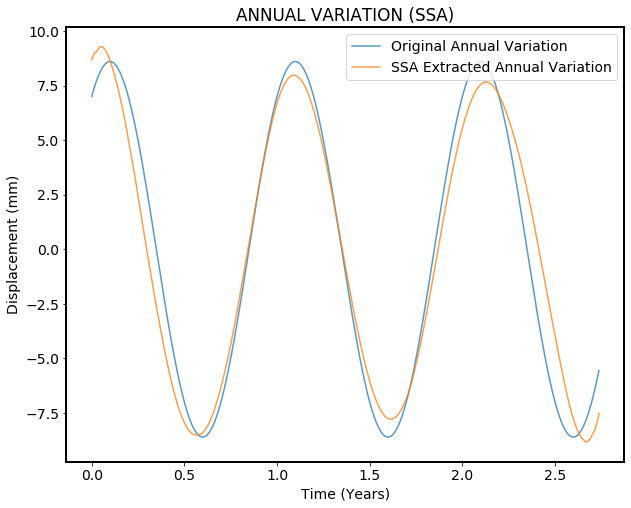

In [11]:
plt.plot(t,periodic1,alpha=0.75,label = 'Original Annual Variation')
plt.plot(t,F_periodic1,alpha=0.75, label= 'SSA Extracted Annual Variation')
plt.legend(loc='upper right')
plt.title('ANNUAL VARIATION (SSA)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('annual_var_ssa.png')
plt.show()

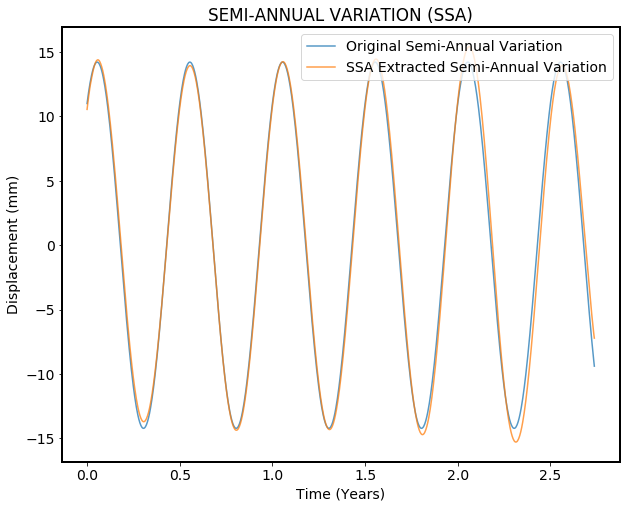

In [12]:
plt.plot(t,periodic2,alpha=0.75,label = 'Original Semi-Annual Variation')
plt.plot(t,F_periodic2,alpha=0.75, label= 'SSA Extracted Semi-Annual Variation')
plt.legend(loc='upper right')
plt.title('SEMI-ANNUAL VARIATION (SSA)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('semi_annual_var_ssa.png')
plt.show()

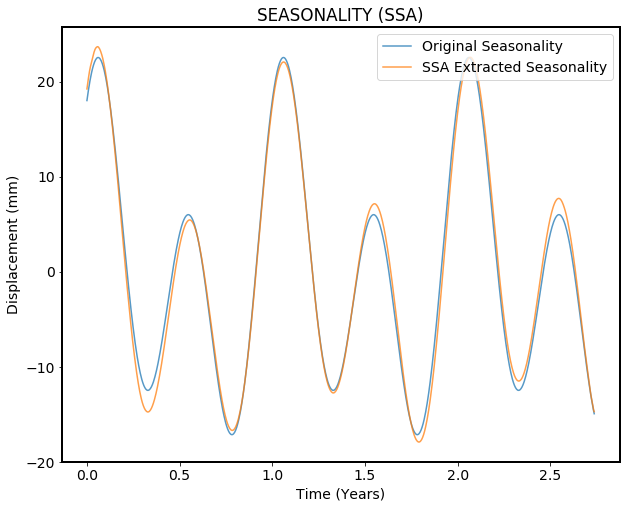

In [13]:
plt.plot(t,seasonality,alpha=0.75,label = 'Original Seasonality')
plt.plot(t,F_periodic1+F_periodic2,alpha=0.75, label= 'SSA Extracted Seasonality')
plt.legend(loc='upper right')
plt.title('SEASONALITY (SSA)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('seasonality_var_ssa.png')
plt.show()

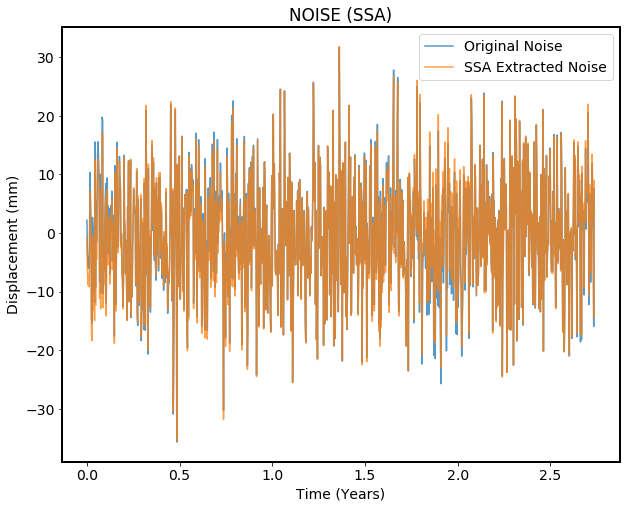

In [14]:
plt.plot(t,noise,alpha=0.75,label = 'Original Noise')
plt.plot(t,F_noise,alpha=0.75, label= 'SSA Extracted Noise')
plt.legend(loc='upper right')
plt.title('NOISE (SSA)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('noise_var_ssa.png')
plt.show()

# Least Squares

In [15]:
# Design Matrix
N = len(F)
A = np.empty((N,4))
for i in range(0,N):
    A[i,0] = sin(2*pi*t[i])
    A[i,1] = cos(2*pi*t[i])
    A[i,2] = sin(4*pi*t[i])
    A[i,3] = cos(4*pi*t[i])

In [16]:
# X = Coefficient Matrix

X = inv(A.T @ A) @ A.T @ F

In [17]:
least_square_season = A @ X

In [18]:
ls_annual = A[:,0] *X[0] + A[:,1] *X[1]
ls_semi_annual = A[:,2] *X[2] + A[:,3] *X[3]
ls_noise = F - (ls_annual+ls_semi_annual).reshape(-1,1)

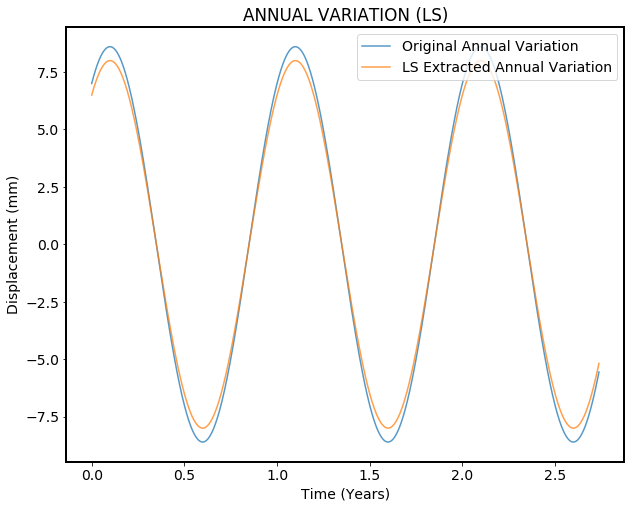

In [19]:
plt.plot(t,periodic1,alpha=0.75,label = 'Original Annual Variation')
plt.plot(t,ls_annual,alpha=0.75, label= 'LS Extracted Annual Variation')
plt.legend(loc='upper right')
plt.title('ANNUAL VARIATION (LS)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('annual_var_ls.png')
plt.show()

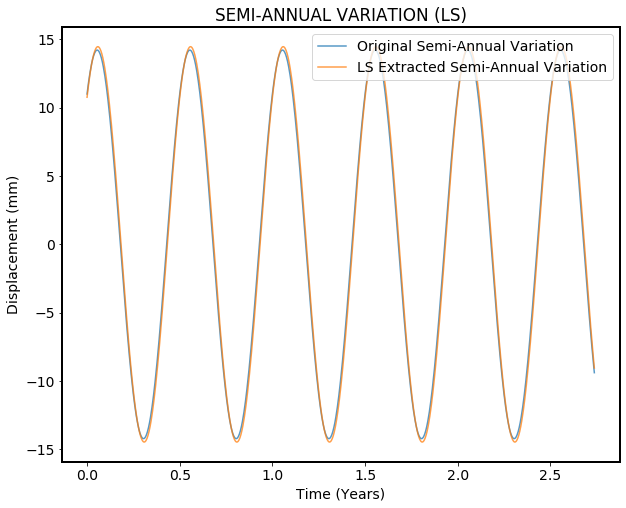

In [20]:
plt.plot(t,periodic2,alpha=0.75,label = 'Original Semi-Annual Variation')
plt.plot(t,ls_semi_annual,alpha=0.75, label= 'LS Extracted Semi-Annual Variation')
plt.legend(loc='upper right')
plt.title('SEMI-ANNUAL VARIATION (LS)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('semi_annual_var_ls.png')
plt.show()

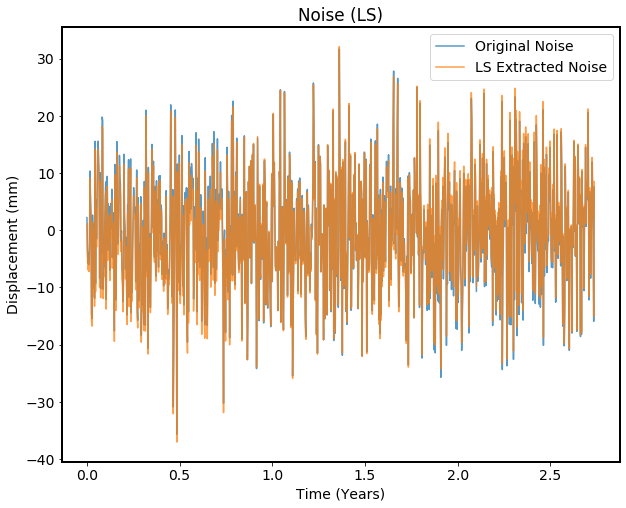

In [21]:
plt.plot(t,noise,alpha=0.75,label = 'Original Noise')
plt.plot(t,ls_noise,alpha=0.75, label= 'LS Extracted Noise')
plt.legend(loc='upper right')
plt.title('Noise (LS)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('noise_var_ls.png')
plt.show()

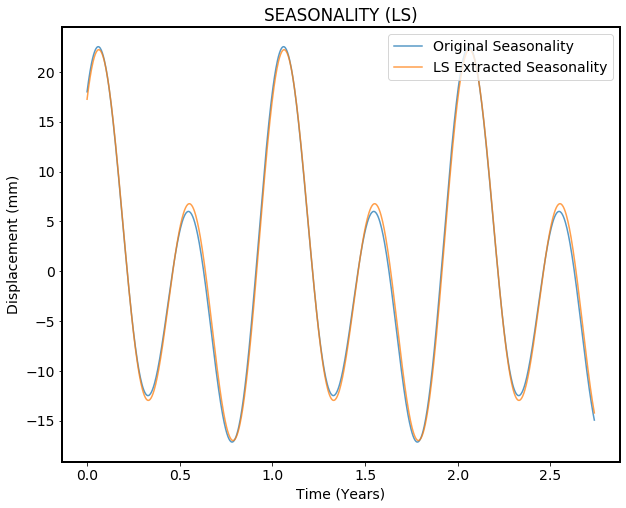

In [22]:
plt.plot(t,seasonality,alpha=0.75,label = 'Original Seasonality')
plt.plot(t,ls_annual+ls_semi_annual,alpha=0.75, label= 'LS Extracted Seasonality')
plt.legend(loc='upper right')
plt.title('SEASONALITY (LS)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('seasonality_var_ls.png')
plt.show()

# Comparing SSA vs LS

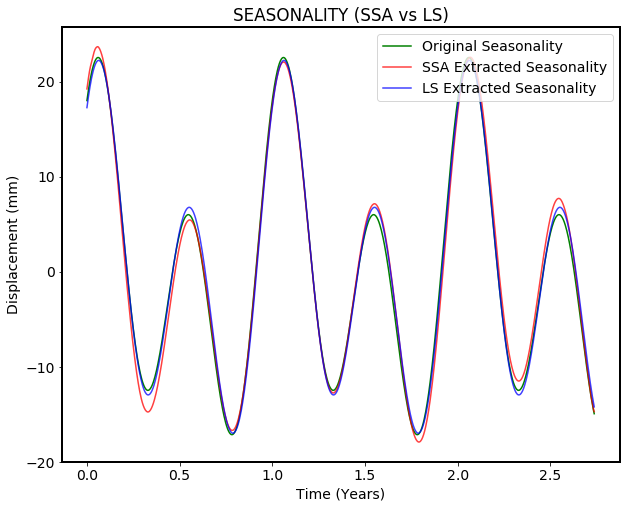

In [23]:
plt.plot(t,seasonality,alpha=1,label = 'Original Seasonality',color = 'green')
plt.plot(t,F_periodic1+F_periodic2,alpha=0.75, label= 'SSA Extracted Seasonality',color='red')
plt.plot(t,ls_annual+ls_semi_annual,alpha=0.75, label= 'LS Extracted Seasonality',color='blue')
plt.legend(loc='upper right')
plt.title('SEASONALITY (SSA vs LS)')
plt.ylabel('Displacement (mm)')
plt.xlabel('Time (Years)')
plt.savefig('compare_ssa_ls.png')
plt.show()

In [24]:
mean_squared_error(seasonality,ls_annual+ls_semi_annual) # MSE for Least Squares

0.4243321811390167

In [25]:
mean_squared_error(seasonality,F_periodic1+F_periodic2) #MSE for SSA

1.2668771275830704